In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')


In [3]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/blasting/TFG_TimeSeries/notebooks/utils.py:132: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the row

In [4]:
X_val.shape

(8659, 96, 1)

In [5]:
y_val.shape

(8659, 6)

In [19]:

n_neurons_per_layer = int(2/3*(X_train.shape[1]*X_train.shape[2]))

inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
flatten_outputs = tfk.layers.Flatten()(inputs)
dnn_output = tfk.layers.Dense(n_neurons_per_layer, activation='relu')(flatten_outputs)
dnn_output = tfk.layers.Dense(n_neurons_per_layer,
activation='relu')(dnn_output)

outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(dnn_output)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 10,758
Trainable params: 10,758
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=50, 
                    validation_data=(X_val, y_val)) 


loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion
#val_mse = history.history['val_mse']    #validacion
#mse = history.history['mse']    #validacion


Epoch 1/50
68/68 [==============================] - 1s 5ms/step - loss: 0.4256 - mean_absolute_error: 0.4976 - val_loss: 0.0924 - val_mean_absolute_error: 0.2221
Epoch 2/50
68/68 [==============================] - 0s 3ms/step - loss: 0.0792 - mean_absolute_error: 0.2030 - val_loss: 0.0578 - val_mean_absolute_error: 0.1710
Epoch 3/50
68/68 [==============================] - 0s 3ms/step - loss: 0.0538 - mean_absolute_error: 0.1648 - val_loss: 0.0466 - val_mean_absolute_error: 0.1525
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 0.0441 - mean_absolute_error: 0.1473 - val_loss: 0.0465 - val_mean_absolute_error: 0.1513
Epoch 5/50
68/68 [==============================] - 0s 3ms/step - loss: 0.0393 - mean_absolute_error: 0.1385 - val_loss: 0.0365 - val_mean_absolute_error: 0.1337
Epoch 6/50
68/68 [==============================] - 0s 3ms/step - loss: 0.0345 - mean_absolute_error: 0.1297 - val_loss: 0.0349 - val_mean_absolute_error: 0.1298
Epoch 7/50
68/68 [==========

In [54]:
np.save( 'arrays_guardados/loss_dense',              history.history['loss'])
np.save( 'arrays_guardados/loss_dense_val',
    history.history['val_loss'])

In [21]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [22]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [23]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [24]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 274.066129
t+2 MSE: 346.015041
t+3 MSE: 388.387586
t+4 MSE: 450.676085
t+5 MSE: 482.717336
t+6 MSE: 514.130255
validacion
t+1 MSE: 282.221500
t+2 MSE: 351.311113
t+3 MSE: 392.440171
t+4 MSE: 460.428087
t+5 MSE: 494.893085
t+6 MSE: 525.071778


In [1]:
(274.066129 + 346.015041 + 388.387586 + 450.676085 + 482.717336 + 514.130255)/6

409.332072

In [32]:
y_hat.shape

(8587, 6)

(144,)
(144,)


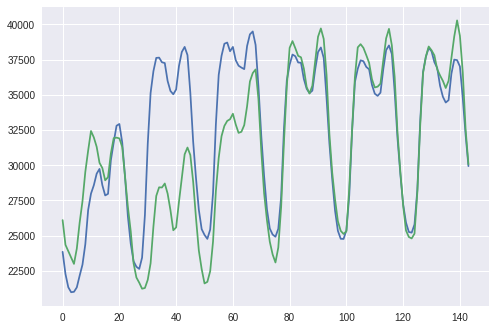

In [52]:
# plot the entire dataset in blue

test_size = 144
real_data = scaler.inverse_transform(X_val[test_size:2*test_size, 0, 0])
print(real_data.shape)
forecastings = y_hat[:test_size, 0]
print(forecastings.shape)
plt.plot(real_data)
plt.plot(forecastings)
# plot the forecasts in red
#for i in range(len(forecastings)):
    #xaxis = np.arange(i, forecastings.shape[1]+i)
    #if xaxis[-1] > real_data.shape[0]-1:
    #    continue
    #plt.plot(xaxis, forecastings[i], color='red')
# show the plot
#plt.show()

In [24]:
real_data

array([23573, 27320, 29847, 30525, 31152, 31389, 31555, 31677, 30842,
       30088, 29718, 29530, 29158, 30599, 32656, 31816, 29002, 26348,
       24640, 23335, 22510, 22242, 22121, 22488, 24522, 28178, 30532,
       30951, 31368, 31675, 31922, 31899, 30989, 30375, 30052, 29870,
       29373, 30794, 32774, 31876, 29102, 26608, 25006, 23652, 22822,
       22407, 22457, 22637, 24536, 28148, 30396, 30693, 31304, 31611,
       31554, 31598, 30697, 30035, 29854, 29619, 29312, 30648, 32832,
       31856, 28867, 26404, 24684, 23533, 22658, 22349, 22257, 22585,
       24436, 28086, 30428, 30853, 31376, 31455, 31794, 31791, 30931,
       30306, 30021, 29796, 29367, 30822, 32584, 31742, 28825, 26559,
       24945, 23727, 22854, 22418, 22402, 22755, 24550, 28300, 30464,
       30980, 31402, 31782, 32010, 31984, 31031, 30190, 29746, 29520,
       29446, 30979, 32196, 31306, 28753, 26555, 25187, 23772, 22581,
       21928, 21515, 21266, 21741, 22992, 24503, 26113, 27774, 28339,
       28527, 28610,

In [25]:
forecastings

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [27741.371, 27844.195, 27507.217, 26406.424, 25654.86 , 25659.986],
       [27286.21 , 26843.74 , 26262.05 , 25154.06 , 25195.504, 26641.361],
       [26985.578, 25947.916, 25098.5  , 25421.86 , 26543.797, 28172.568]],
      dtype=float32)